# Preperation

### Imports

In [1]:
import os
import sys

import torch
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
sys.path.append(os.path.abspath('../../src'))

from model_training import gru
from helper_functions import visualization as visual

### Paths

In [3]:
structure, output_dir, log_dir = gru.setup_paths()

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection


# Training

### Train config

In [4]:
config = {
    'data_amount': 100000,
    'embedding_dim': 32,
    'hidden_dim': 64,
    'output_dim': 2,  
    'max_len': 100,
    'batch_size': 64,
    'num_epochs': 15,
    'learning_rate': 1e-3,
    'lr_scheduler_type': "reduce_lr_on_plateau",
    'weight_decay': 1e-5,
    'logging_steps': 100,
    'evaluation_strategy': "epoch",
    'save_strategy': "epoch",
    'early_stopping_patience': 5,
}

### Prepare data

In [5]:
url_data, le = gru.load_data(structure, config['data_amount'])
X_train, X_val, X_test, y_train, y_val, y_test = gru.split_data(url_data)
X_train_indices, X_val_indices, X_test_indices, vocab = gru.tokenize_urls(X_train, X_val, X_test)
train_loader, val_loader, test_loader = gru.prepare_dataloader(X_train_indices, X_val_indices, X_test_indices, y_train, y_val, y_test)


=== Updated Class Distribution (Phishing = 0, Legit = 1)===
status
1    51949
0    48051
Name: count, dtype: int64 


=== Class Distribution After Splitting ===
TRAIN:
 status
1    33247
0    30753
Name: count, dtype: int64 

VALIDATION:
 status
1    8312
0    7688
Name: count, dtype: int64 

TEST:
 status
1    10390
0     9610
Name: count, dtype: int64 


=== Vocabulary Information ===
Vocabulary size: 138486


=== Dataset Sizes ===
Train dataset size: 64000
Validation dataset size: 16000
Test dataset size: 20000



### Create model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = gru.GRUModel(
    vocab_size=len(vocab),
    embedding_dim=config['embedding_dim'],
    hidden_dim=config['hidden_dim'],
    output_dim=config['output_dim'],
    max_len=config['max_len']
).to(device)

In [8]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3,
    weight_decay=config['weight_decay']
)

In [9]:
#cheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

### Train model

In [10]:
gru.train_evaluate(
    model, train_loader, val_loader, optimizer, scheduler, config, device, output_dir, log_dir
)


--------------------------- Start Epoch 1 ---------------------------
Train Step [100] - Train Loss: 0.6896 -Train Accuracy: 0.6452 - Learning Rate: 0.001000
Train Step [200] - Train Loss: 0.4365 -Train Accuracy: 0.7229 - Learning Rate: 0.001000
Train Step [300] - Train Loss: 0.1925 -Train Accuracy: 0.7604 - Learning Rate: 0.001000
Train Step [400] - Train Loss: 0.2616 -Train Accuracy: 0.7852 - Learning Rate: 0.001000
Train Step [500] - Train Loss: 0.2756 -Train Accuracy: 0.8038 - Learning Rate: 0.001000
Train Step [600] - Train Loss: 0.2178 -Train Accuracy: 0.8173 - Learning Rate: 0.001000
Train Step [700] - Train Loss: 0.3070 -Train Accuracy: 0.8286 - Learning Rate: 0.001000
Train Step [800] - Train Loss: 0.2203 -Train Accuracy: 0.8381 - Learning Rate: 0.001000
Train Step [900] - Train Loss: 0.1220 -Train Accuracy: 0.8452 - Learning Rate: 0.001000
Train Step [1000] - Train Loss: 0.3138 -Train Accuracy: 0.8515 - Learning Rate: 0.001000

End of Epoch 1 - Train Loss:     0.3445 - Train

### Evaluate on Test

In [11]:
all_preds, all_labels, all_probs = gru.evaluate_on_test(model, test_loader)

### Load trained model

In [12]:
model = gru.load_model(output_dir, len(vocab), config)

c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\src\model_training\gru.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

# Visualization

In [13]:
metrics = visual.extract_metrics_from_events(log_dir)

### Loss x Epochs & Accuracy x Epochs

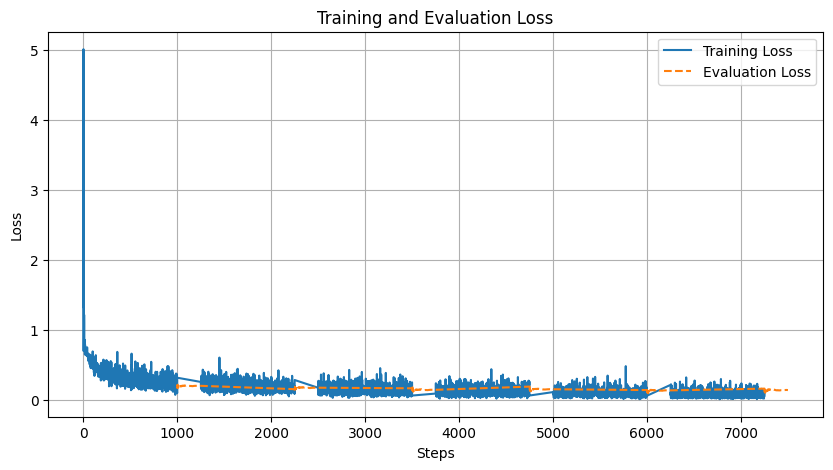

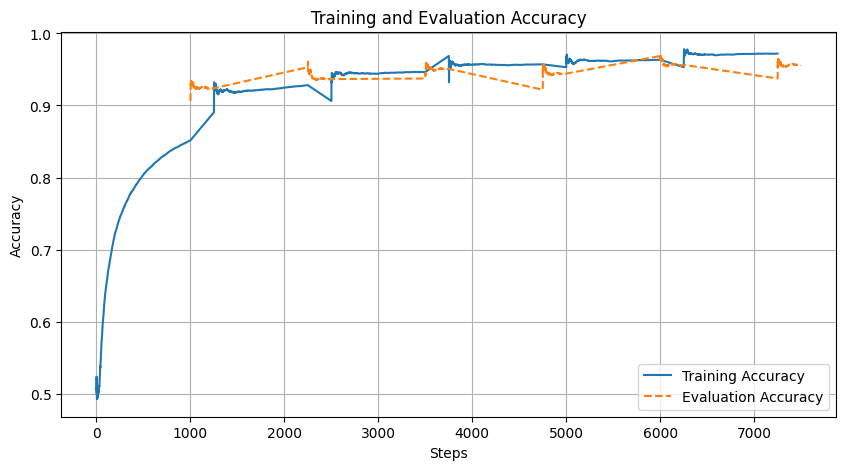

In [14]:
visual.plot_loss_and_accuracy(metrics, output_dir)

### Confusion Matrix

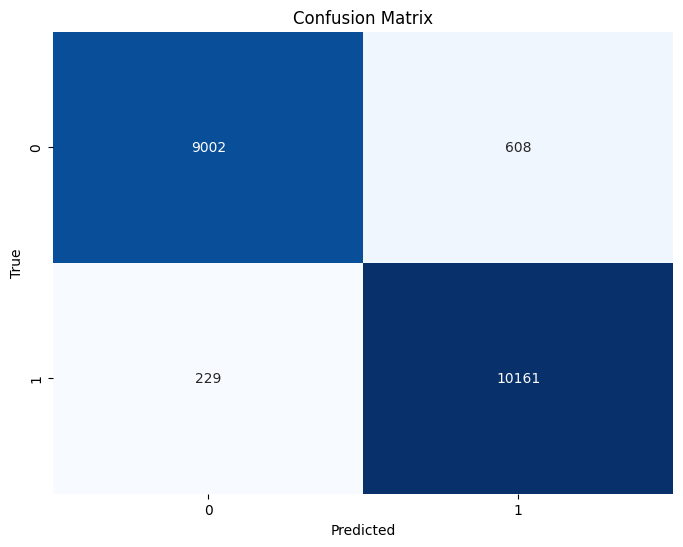

In [15]:
cm = confusion_matrix(all_labels, all_preds)
visual.plot_confusion_matrix(cm, output_dir, "test")

### ROC

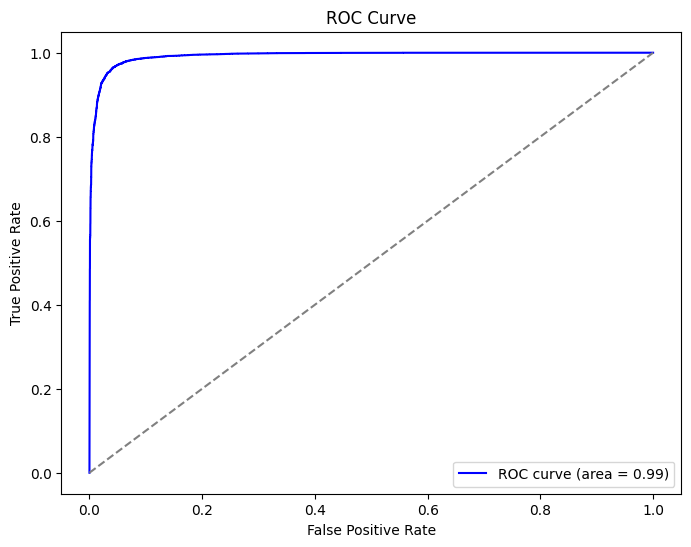

In [16]:
visual.plot_roc_curve(all_labels, all_probs, output_dir)

### Precision - Recall

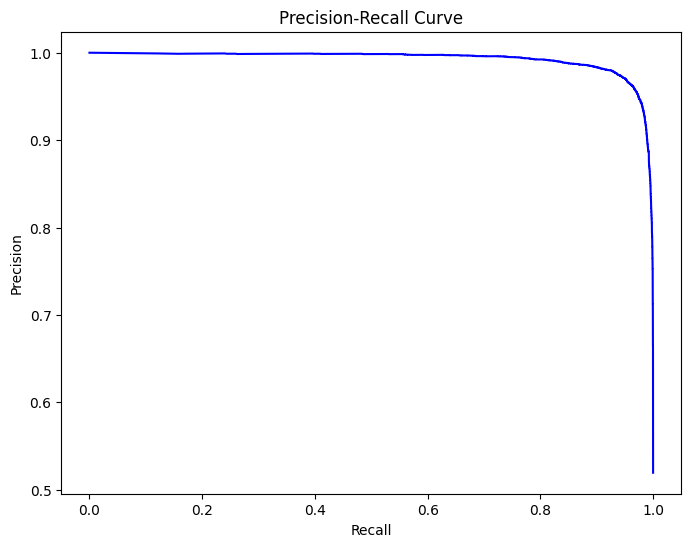

In [17]:
visual.plot_precision_recall(all_labels, all_probs, output_dir)

### Classification Report

In [18]:
report = classification_report(all_labels, all_preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

,precision,recall,f1-score,support
0,0.975192,0.936733,0.955576,9610.00000
1,0.943542,0.977960,0.960442,10390.00000
accuracy,0.958150,0.958150,0.958150,0.95815
macro avg,0.959367,0.957346,0.958009,20000.00000
weighted avg,0.958750,0.958150,0.958104,20000.00000


### Other tracked scalars

In [19]:
visual.list_scalar_tags_and_histograms(log_dir)

Scalar Tags:
train/loss
train/accuracy
Learning Rate
train/epoch_loss
train/epoch_accuracy
eval/loss
eval/accuracy
eval/epoch_loss
eval/epoch_accuracy

Histogram Tags:


In [20]:
scalar_tag = "Learning Rate"

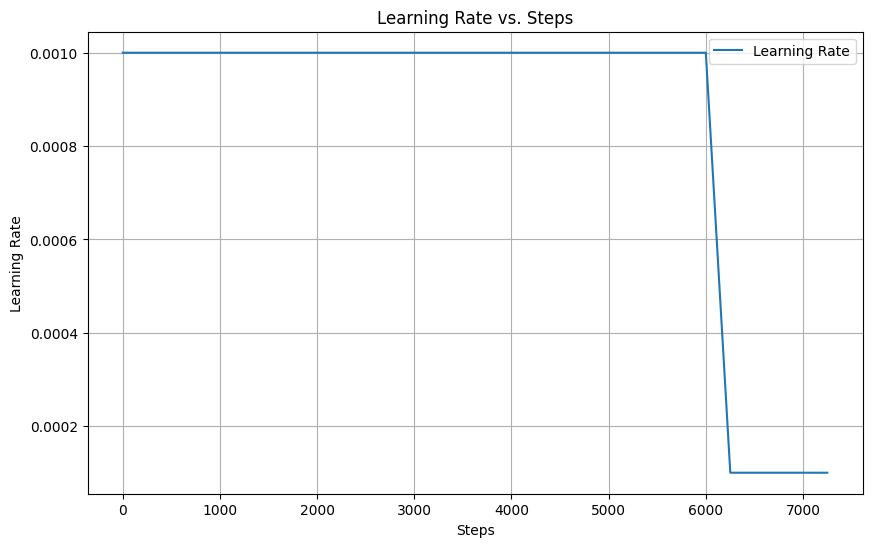

In [21]:
visual.plot_scalar_metric(log_dir, scalar_tag)

### Inference on samples

In [22]:
# Define test URLs and true labels
test_urls = [
    "https://www.paypa1-secure.com/login",
    "secure-login-facebook.com/auth",
    "http://amz.to",
    "https://miriamrecipes.com",
    "https://traveldoc.com",
    "https://www.google.com"
]

true_labels = [0, 0, 0, 1, 1, 1]

print("Test URLs and True Labels:")
for url, label in zip(test_urls, true_labels):
    print(f"URL: {url}, Label: {label}")

# Perform inference
all_preds, all_probs = gru.inference_on_urls(model, test_urls, vocab, device)

# Print predictions and comparison with true labels
print("\n=== Model Predictions ===")
for url, true_label, pred, prob in zip(test_urls, true_labels, all_preds, all_probs):
    print(f"URL: {url}")
    print(f"True Label: {true_label}, Predicted Label: {pred}, Probabilities: {prob}")
    print("-" * 60)

Test URLs and True Labels:
URL: https://www.paypa1-secure.com/login, Label: 0
URL: secure-login-facebook.com/auth, Label: 0
URL: http://amz.to, Label: 0
URL: https://miriamrecipes.com, Label: 1
URL: https://traveldoc.com, Label: 1
URL: https://www.google.com, Label: 1

=== Model Predictions ===
URL: https://www.paypa1-secure.com/login
True Label: 0, Predicted Label: 0, Probabilities: [9.999906e-01 9.475094e-06]
------------------------------------------------------------
URL: secure-login-facebook.com/auth
True Label: 0, Predicted Label: 0, Probabilities: [0.96174455 0.03825543]
------------------------------------------------------------
URL: http://amz.to
True Label: 0, Predicted Label: 0, Probabilities: [9.994475e-01 5.525224e-04]
------------------------------------------------------------
URL: https://miriamrecipes.com
True Label: 1, Predicted Label: 0, Probabilities: [9.9998474e-01 1.5240405e-05]
------------------------------------------------------------
URL: https://traveldoc.

In [23]:
all_preds, all_probs = gru.inference_on_urls(model, test_urls, vocab, device)

# Evaluate predictions against true labels
from sklearn.metrics import classification_report

print("\n=== Classification Report ===")
print(classification_report(true_labels, all_preds, target_names=["Legitimate", "Phishing"]))


=== Classification Report ===
              precision    recall  f1-score   support

  Legitimate       0.50      1.00      0.67         3
    Phishing       0.00      0.00      0.00         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\phishing_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

### Inference on only augmented data

In [24]:
augmented_url_csv = structure.data.preprocessed.data_for_gru.phishing_urls_augmented_csv
augmented_data = pd.read_csv(augmented_url_csv)
augmented_data = augmented_data.head(50) 

In [25]:
urls = augmented_data['url'].tolist()
true_labels = augmented_data['status'].tolist()

In [26]:
all_preds, all_probs = gru.inference_on_urls(model, urls, vocab, device)

In [27]:
augmented_data['prediction'] = all_preds
augmented_data['probabilities'] = all_probs

print(augmented_data[['url', 'prediction', 'probabilities']].head())

                   url  prediction                probabilities
0   https://google.com           0  [0.99997365, 2.6396632e-05]
1          lgoogle.com           0   [0.9995896, 0.00041043558]
2          youtube.com           0    [0.9981918, 0.0018082631]
3  contact.youtube.com           0   [0.99911827, 0.0008817485]
4         facebook.com           0     [0.9979169, 0.002083162]
